In [ ]:
!git clone https://github.com/ialexmp/IRWA.git

Cloning into 'IRWA'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 2.26 MiB | 4.50 MiB/s, done.


In [ ]:
%cd IRWA/Data_1/

/content/IRWA/Data_1


In [ ]:
import pandas as pd
import json
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
# evaluation_gt = pd.read_csv("Evaluation_gt.csv")
tweet_document_ids_map = pd.read_csv("Rus_Ukr_war_data_ids.csv", sep="\t", names=["doc", "tweet_id"])
rus_ukr_war_data = []
with open("Rus_Ukr_war_data.json") as f:
  for line in f:
   json_object = json.loads(line)
   rus_ukr_war_data.append(json_object)

In [ ]:
print("Total number of tweets related to the Russo-Ukrainian War: {}".format(len(rus_ukr_war_data)))

Total number of tweets related to the Russo-Ukrainian War: 4000


# **1. Pre-process**


* Removing stop words
* Tokenization
* Removing punctuation marks
* Stemming
* Anything else needed **(bonus point)**




In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stemmer = nltk.stem.SnowballStemmer('english')
custom_stopwords = set(stopwords.words('english'))

In [ ]:
#preprocess function to include stopword removal, tokenization, punctiation marls removal, stemming, newline characters removal and extra whitespaces removal
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove newline characters
    text = text.replace('\\n', '')
    # Remove extra whitespaces
    text = ' '.join(text.split())
    # Delete URLs on the tweet because we won't be able to access to them
    text = re.sub(r'\S*https?:\S*', '', text)
    # Remove spaces at first and at the end of a message
    text.strip()
    # Remove punctuation
    text = re.sub(r'[^a-z0-9#@ ]+', '', text)
    # Tokenize the text
    words = text.split()
    # Remove stopwords and apply stemming
    processed_words = [stemmer.stem(word) for word in words if word not in custom_stopwords]
    return ' '.join(processed_words)

In [ ]:
def preprocess_date(text):
  # Convert date to dd/mm/yyyy
  return pd.to_datetime(datetime.strptime(text, "%a %b %d %H:%M:%S %z %Y").strftime("%d/%m/%Y"), format='%d/%m/%Y')

In [ ]:
processed_data = []
tweet_ids = []
data_df = pd.DataFrame(columns=['Tweet', 'Date', 'Hashtags', 'Likes', 'Retweets', 'Url'])
for line in rus_ukr_war_data:
    processed_text = preprocess(line["full_text"])
    hashtags_list = [preprocess(hashtag["text"]) for hashtag in line["entities"]["hashtags"]]
    hashtags = ', '.join(hashtags_list)
    tweet_id = line["id_str"]
    tweet_ids.append(tweet_id)
    user = line["user"]["screen_name"]
    url = f"https://twitter.com/{user}/status/{tweet_id}"
    date = preprocess_date(line["created_at"])
    processed_data.append(processed_text + '|' + str(date) + '|' + str(len(hashtags.split(", "))) + '|' + str(line["favorite_count"]) + '|' + str(line["retweet_count"]) + '|' + url)
    data_df.loc[len(data_df)] = {"Tweet": processed_text, "Date": date, "Hashtags": len(hashtags.split(", ")), "Likes": line["favorite_count"], "Retweets": line["retweet_count"], "Url": url}

In [ ]:
print(processed_data[7])
data_df.head(8)

#ukrainerussiawar #ukrain #russia #osc condemn russia illeg annex ukrainian territori call russian feder withdraw forc across ukrain|2022-09-30 00:00:00|4|0|0|https://twitter.com/EUFreeCitizen/status/1575917748978434053


,Tweet,Date,Hashtags,Likes,Retweets,Url
0,@melsimmonsfcdo wrong dictat putin fascist rus...,2022-09-30,2,0,0,https://twitter.com/LynBank25442089/status/157...
1,arm forc liber villag #drobyshev #lymansk urba...,2022-09-30,12,0,0,https://twitter.com/Feher_Junior/status/157591...
2,alert poland prep antiradi tablet nuclear thre...,2022-09-30,6,0,0,https://twitter.com/NEWS_ALL_TIME/status/15759...
3,im still wait googl map updat russia new annex...,2022-09-30,2,0,0,https://twitter.com/Magzprestige/status/157591...
4,@emmanuelmacron probabl your right say anyway ...,2022-09-30,2,0,0,https://twitter.com/t3zx9kc7rs1/status/1575917...
5,estonia lithuania latvia fulli support welcom ...,2022-09-30,4,0,0,https://twitter.com/NEWS_ALL_TIME/status/15759...
6,nato ukrain poke bear russia get mad bear russ...,2022-09-30,4,0,0,https://twitter.com/A0zeir/status/157591775136...
7,#ukrainerussiawar #ukrain #russia #osc condemn...,2022-09-30,4,0,0,https://twitter.com/EUFreeCitizen/status/15759...


# **2. Exploratory Data Analysis**

## Tweet

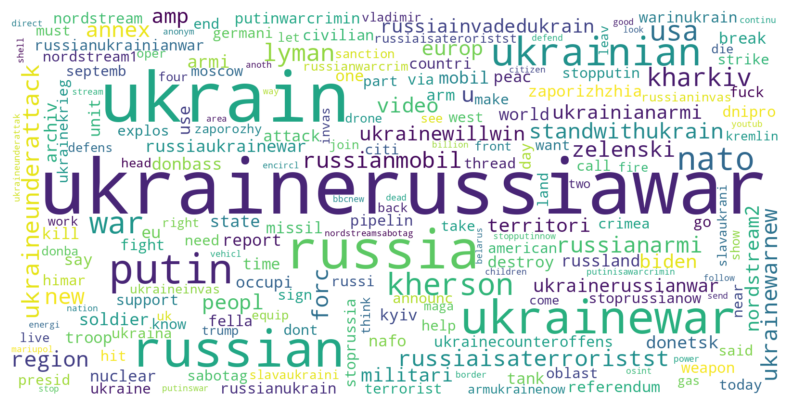

In [ ]:
# Word Cloud
all_tweets = ' '.join(data_df['Tweet'])
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(all_tweets) #Collocations = False to avoid bigrams.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Most Mentioned User Analysis
data_df["mentions"] = data_df["Tweet"].str.findall(r'@(\w+)')
users = data_df.explode("mentions")["mentions"].value_counts()
print(users[:10])

zelenskyyua    44
youtub         40
potus          31
mfarussia      22
eucommiss      22
russiaun       21
ukrain         20
nato           20
defenceu       19
cnn            12
Name: mentions, dtype: int64


## Date

In [ ]:
# There is some tweet about the war before it started?
data_df[data_df["Date"] <= pd.to_datetime('2020-02-24')]

,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions


## Hashtags



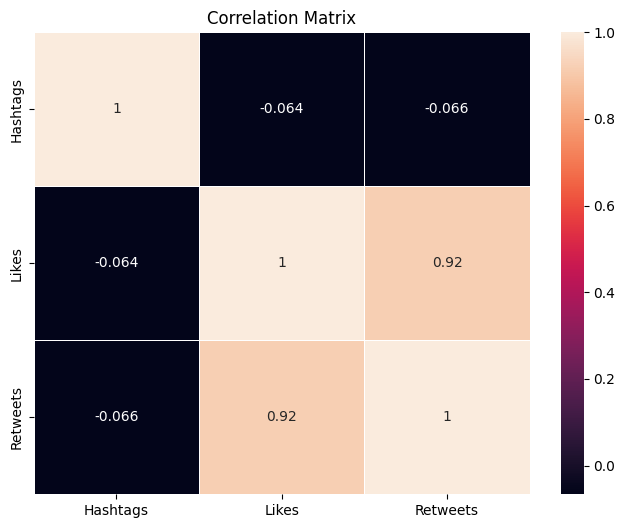

In [ ]:
# Correlation Matrix
data_corr = data_df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(data_corr, annot=True, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

## Likes

In [ ]:
# Descriptive Statistics about the likes
data_df["Likes"].describe()

count    4000.000000
mean       11.436250
std       100.265304
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max      3701.000000
Name: Likes, dtype: float64

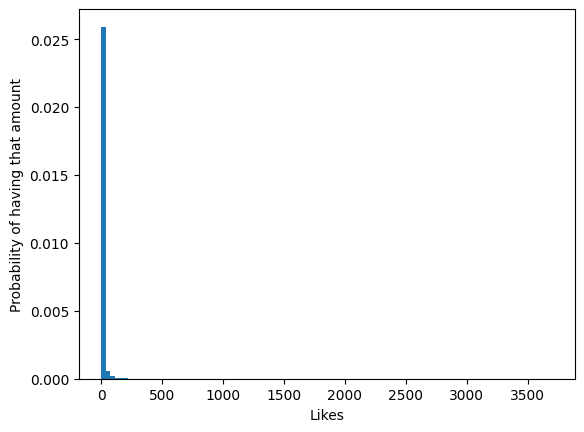

In [ ]:
# Histogram about the Likes and their probability
likes = data_df["Likes"]
plt.hist(likes, bins=100, density=True)
plt.xlabel("Likes")
plt.ylabel("Probability of having that amount")
plt.show()

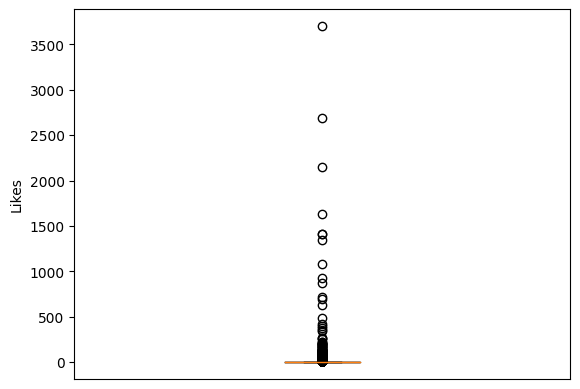

In [ ]:
# Boxplot Likes
plt.boxplot(likes)
plt.ylabel("Likes")
plt.gca().set_xticks([])
plt.show()

In [ ]:
# Top 10 most liked tweets
viral_tweets = data_df.sort_values("Likes", ascending = False)
viral_tweets.head(10)

,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
1219,situat around lyman sep 30 1100 ua forc liber ...,2022-09-30,1,3701,646,https://twitter.com/Militarylandnet/status/157...,[]
2813,uniqu rare photo ukrainian forward command pos...,2022-09-29,2,2685,338,https://twitter.com/Militarylandnet/status/157...,[]
3765,oper interflex ukrainian recruit continu maste...,2022-09-28,1,2155,283,https://twitter.com/Militarylandnet/status/157...,[]
2823,czech volunt ongo offens ukrainian forc #khark...,2022-09-29,2,1631,114,https://twitter.com/Militarylandnet/status/157...,[]
205,ukrainian forc liber drobyshev #donetsk oblast...,2022-09-30,2,1407,171,https://twitter.com/Militarylandnet/status/157...,[]
2118,kostyantyn nemichev command kraken special uni...,2022-09-29,1,1407,136,https://twitter.com/Militarylandnet/status/157...,[]
3801,ukrainian paratroop btr3 offens #kharkiv#donet...,2022-09-28,3,1348,133,https://twitter.com/Militarylandnet/status/157...,[]
450,zelenski announc ukrain submit acceler applic ...,2022-09-30,1,1083,96,https://twitter.com/Militarylandnet/status/157...,[]
1846,follow countri urg citizen leav updat govern m...,2022-09-29,3,923,251,https://twitter.com/OSINTschizo/status/1575625...,[]
1244,ukrainian forc liber yampil #donetsk oblast #u...,2022-09-30,2,868,69,https://twitter.com/Militarylandnet/status/157...,[]


## Retweets

In [ ]:
# Descriptive Statistics about the retweets
data_df["Retweets"].describe()

count    4000.000000
mean        2.123000
std        15.828361
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       646.000000
Name: Retweets, dtype: float64

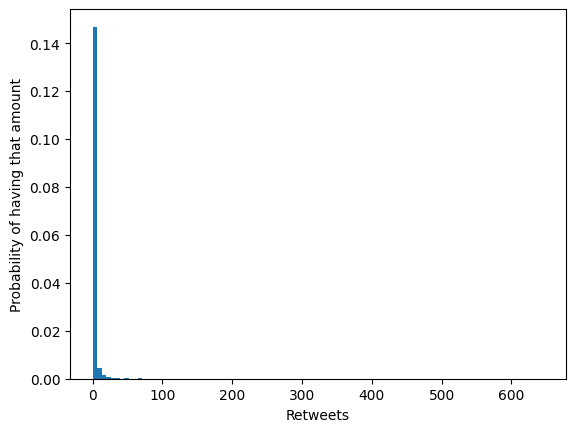

In [ ]:
# Histogram about the Retweets and their probability
retweets = data_df["Retweets"]
plt.hist(retweets, bins=100, density=True)
plt.xlabel("Retweets")
plt.ylabel("Probability of having that amount")
plt.show()

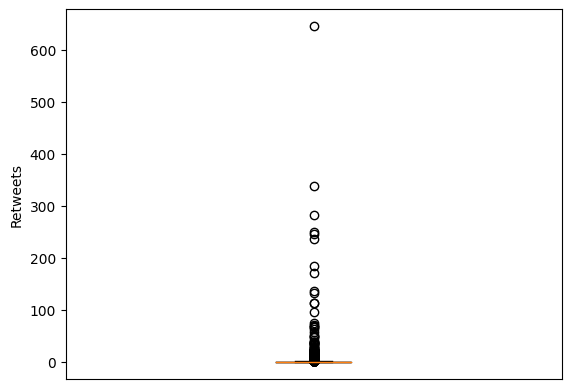

In [ ]:
# Boxplot Likes
plt.boxplot(retweets)
plt.ylabel("Retweets")
plt.gca().set_xticks([])
plt.show()

In [ ]:
# Top 10 most retweeted tweets
most_retweeted_tweets = data_df.sort_values("Retweets", ascending = False)
most_retweeted_tweets.head(10)

,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
1219,situat around lyman sep 30 1100 ua forc liber ...,2022-09-30,1,3701,646,https://twitter.com/Militarylandnet/status/157...,[]
2813,uniqu rare photo ukrainian forward command pos...,2022-09-29,2,2685,338,https://twitter.com/Militarylandnet/status/157...,[]
3765,oper interflex ukrainian recruit continu maste...,2022-09-28,1,2155,283,https://twitter.com/Militarylandnet/status/157...,[]
1846,follow countri urg citizen leav updat govern m...,2022-09-29,3,923,251,https://twitter.com/OSINTschizo/status/1575625...,[]
1387,russian shell outskirt #zaporizhzhia hit civil...,2022-09-30,2,694,247,https://twitter.com/Militarylandnet/status/157...,[]
1209,war end call annex referendum genuin express p...,2022-09-30,3,270,236,https://twitter.com/CyberMartiansio/status/157...,[]
1532,russia may drop 11 meter long x22 missil weigh...,2022-09-30,4,713,184,https://twitter.com/Ukraine66251776/status/157...,[]
205,ukrainian forc liber drobyshev #donetsk oblast...,2022-09-30,2,1407,171,https://twitter.com/Militarylandnet/status/157...,[]
2118,kostyantyn nemichev command kraken special uni...,2022-09-29,1,1407,136,https://twitter.com/Militarylandnet/status/157...,[]
3801,ukrainian paratroop btr3 offens #kharkiv#donet...,2022-09-28,3,1348,133,https://twitter.com/Militarylandnet/status/157...,[]


In [ ]:
# How many tweets contain the word rt or retweet?
contains_rt = data_df["Tweet"].str.contains(r'\brt\b|retweet')
data_contains_rt = data_df[contains_rt].sort_values("Retweets", ascending = False)
print("Head:")
display(data_contains_rt.head())
print("\nTail:")
display(data_contains_rt.tail())

Head:


,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
2981,attent maximum retweet help bring back brother...,2022-09-29,2,3,3,https://twitter.com/PK2451167992/status/157535...,[]
3006,much go world right #ai #art simpli send love ...,2022-09-29,10,5,2,https://twitter.com/YnobeCrypto/status/1575344...,[]
3502,retweet regular occasion tweet #ukrainerussiaw...,2022-09-28,1,11,2,https://twitter.com/B1EMW/status/1575211708829...,[nickreeves9876]
1105,bomber biden strangl life europ retweet agre #...,2022-09-30,5,2,1,https://twitter.com/Socialism4life/status/1575...,[]
1485,follow real time announc peopl report locat uk...,2022-09-30,3,0,0,https://twitter.com/UkraineOnGround/status/157...,[]



Tail:


,Tweet,Date,Hashtags,Likes,Retweets,Url,mentions
1105,bomber biden strangl life europ retweet agre #...,2022-09-30,5,2,1,https://twitter.com/Socialism4life/status/1575...,[]
1485,follow real time announc peopl report locat uk...,2022-09-30,3,0,0,https://twitter.com/UkraineOnGround/status/157...,[]
1625,follow real time inform peopl report present u...,2022-09-30,3,1,0,https://twitter.com/UkraineOnGround/status/157...,[]
3303,@kyivindepend everyon honest free world retwee...,2022-09-28,5,1,0,https://twitter.com/ingold_we/status/157524809...,[kyivindepend]
3499,former everton midfield diniyar bilyaletdinov ...,2022-09-28,2,2,0,https://twitter.com/KorrectSports/status/15752...,[]
